This notebook is heavily based on [this tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning)

# Detecting Frenchies with pretrained ConvNet

## DISCLAIMER
> This notebook is used for presentation and hence the specified problem is extermally oversimplified. This is to present technique and the code itself. The original model was trained on ImageNet dataset and then we transfer knowledge to detect french bulldogs. Data for the target task comes from Stanford Dog Breed dataset which itself is a subset of ImageNet. Beautiful Frenchie that is used as the example input at the end is Gacek, author's own dog.

This notebook contains simple presentation of basic approach to transfer learning in visual domain.

A pre-trained model is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.


In this notebook, you will try one way to customize a pretrained model:

 - Feature Extraction: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset.

 You do not need to (re)train the entire model. The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to the original classification task, and subsequently specific to the set of classes on which the model was trained.

## Few initial imports


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
#if you are running this on MacOS, uncomment line below:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

keras = tf.keras

## Data preprocessing

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 160
BATHC_SIZE = 32

datagen = ImageDataGenerator(
            rescale=1./255.,
            featurewise_center=False,
            featurewise_std_normalization=False,
            rotation_range=90,
            width_shift_range=0.2,
            fill_mode="nearest",
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
    )

train_generator = datagen.flow_from_directory(
        'data/train',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATHC_SIZE,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        'data/validation',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATHC_SIZE,
        class_mode='binary')

Found 437 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


Show the first two images and labels from the training set:

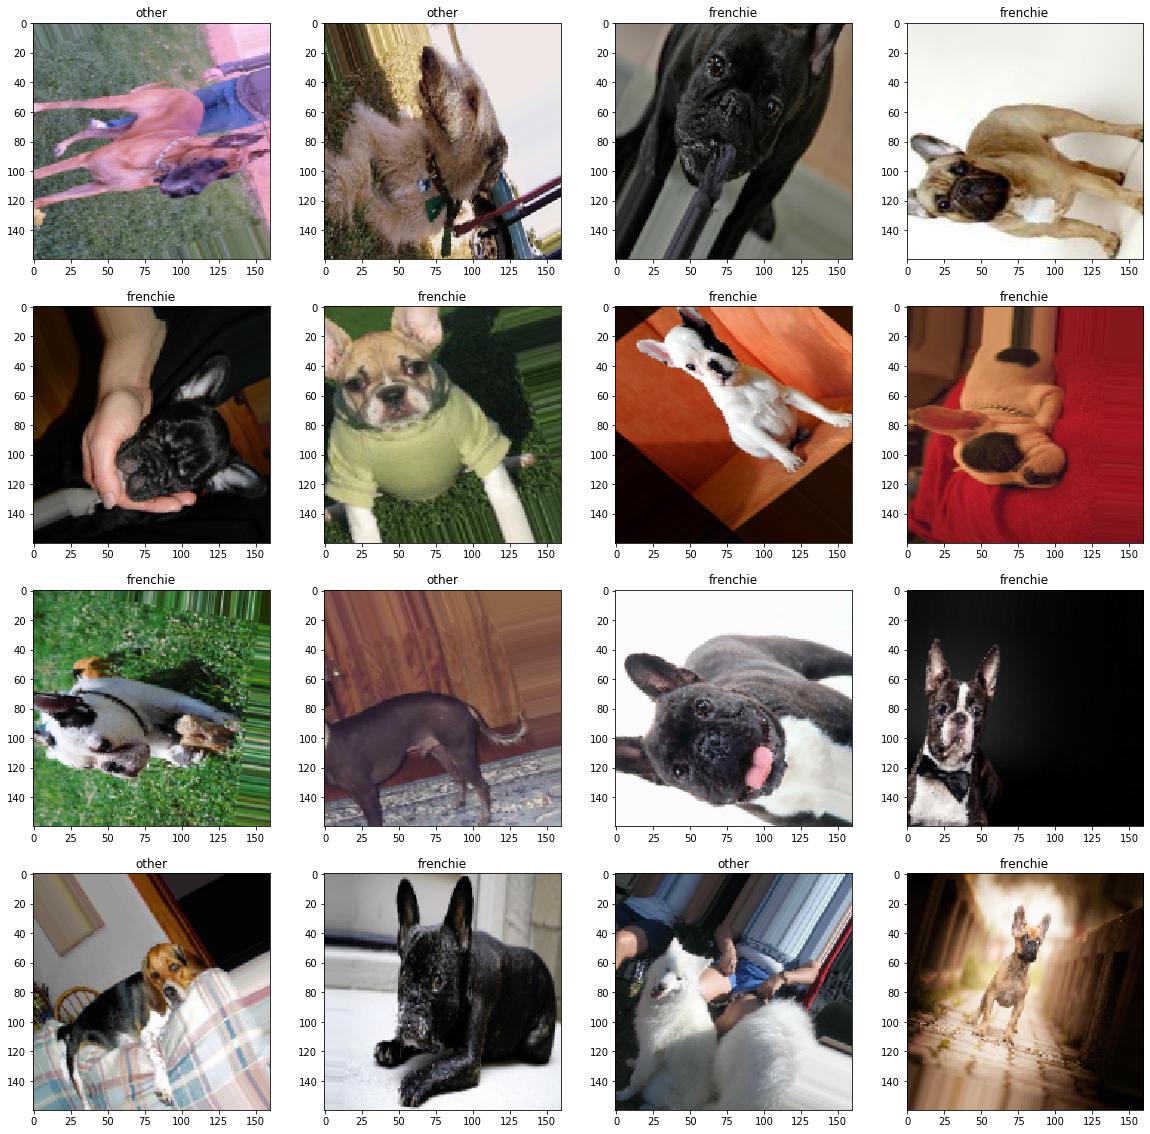

In [4]:
get_label_name = lambda x: "frenchie" if x == 0 else "other"

fig=plt.figure(figsize=(20, 20))
for image_batch, label_batch in train_generator:
    for i in range(0, 16):
      fig.add_subplot(4, 4, i + 1)
      plt.imshow(image_batch[i])
      plt.title(get_label_name(label_batch[i]))
    break

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [5]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

for image_batch, label_batch in train_generator:
   break

image_batch.shape

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. See what it does to the example batch of images:

In [6]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all the layers.

In [7]:
base_model.trainable = False

In [8]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [9]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [10]:
prediction_layer = keras.layers.Dense(1,)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [11]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output.

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [14]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~80% accuracy.


In [15]:
initial_epochs = 10
validation_steps=2

loss0,accuracy0 = model.evaluate(validation_generator, steps = validation_steps)

2/2 [==============================] - 2s 1s/step - loss: 0.7967 - accuracy: 0.5102


In [16]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.51


In [17]:
# Uncomment this to load model
# model = tf.keras.models.load_model("./saved_models/stage_1")

In [18]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=50,
                    validation_data=validation_generator,
                    epochs=initial_epochs)

Epoch 1/10
50/50 [==============================] - 44s 878ms/step - loss: 0.6978 - accuracy: 0.5398 - val_loss: 0.5519 - val_accuracy: 0.6327
Epoch 2/10
50/50 [==============================] - 40s 804ms/step - loss: 0.6284 - accuracy: 0.5890 - val_loss: 0.5015 - val_accuracy: 0.6327
Epoch 3/10
50/50 [==============================] - 41s 813ms/step - loss: 0.5674 - accuracy: 0.6478 - val_loss: 0.4990 - val_accuracy: 0.7347
Epoch 4/10
50/50 [==============================] - 43s 856ms/step - loss: 0.5242 - accuracy: 0.6986 - val_loss: 0.4390 - val_accuracy: 0.7551
Epoch 5/10
50/50 [==============================] - 45s 902ms/step - loss: 0.4955 - accuracy: 0.7243 - val_loss: 0.4771 - val_accuracy: 0.6939
Epoch 6/10
50/50 [==============================] - 43s 862ms/step - loss: 0.4573 - accuracy: 0.7616 - val_loss: 0.4608 - val_accuracy: 0.6735
Epoch 7/10
50/50 [==============================] - 46s 911ms/step - loss: 0.4357 - accuracy: 0.7786 - val_loss: 0.3951 - val_accuracy: 0.7551

In [19]:
# Uncoment line below to save model
# model.save('./saved_models/stage_1') 

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

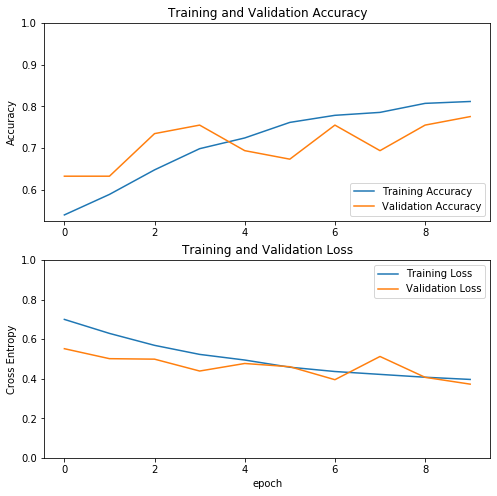

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are sometimes better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Let's see how it works!

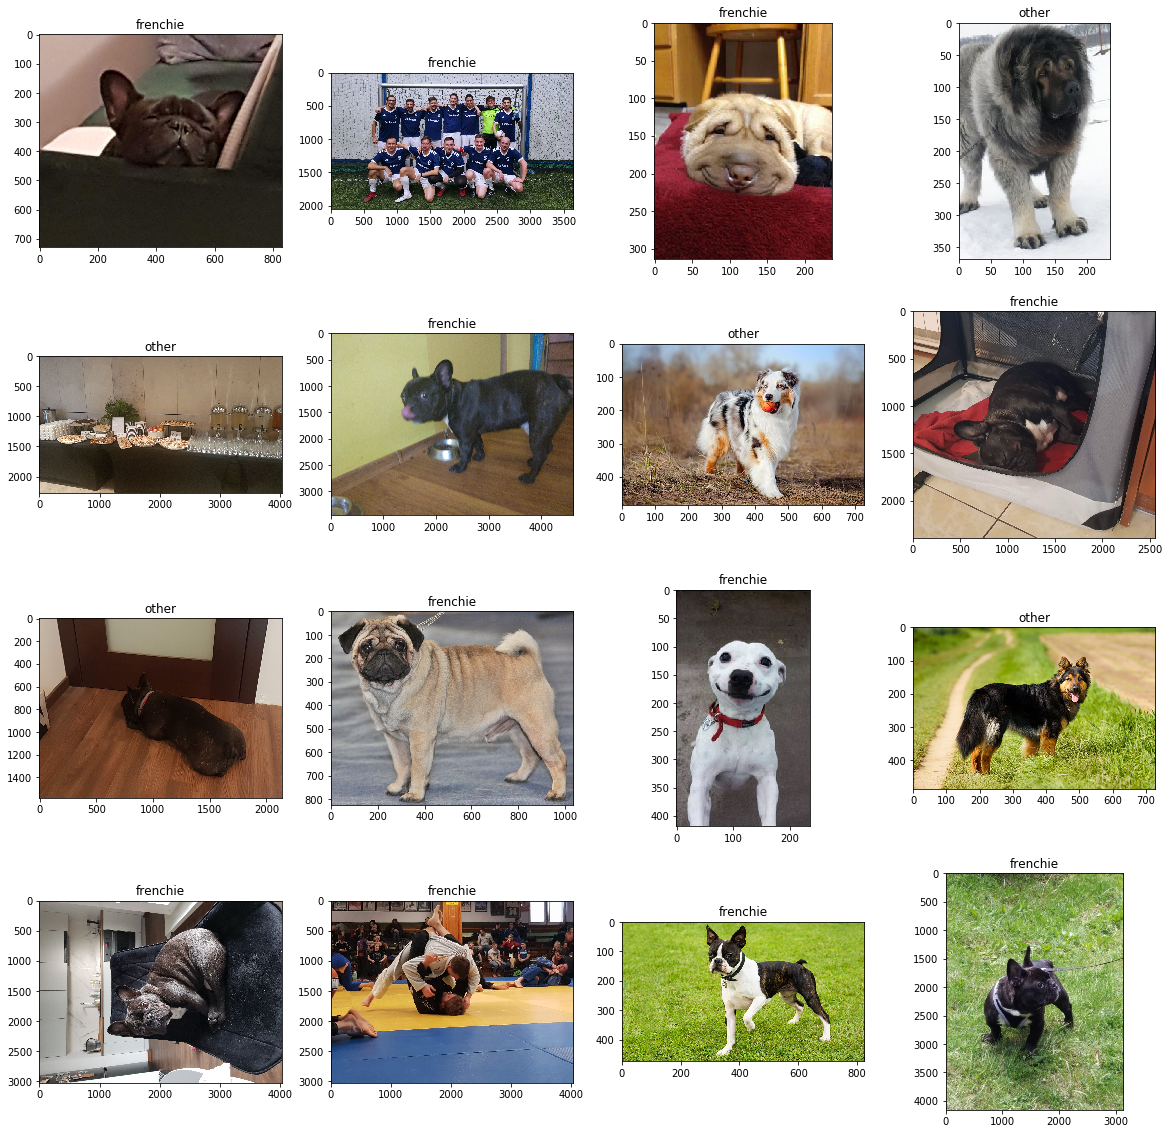

In [21]:
test_images = [keras.preprocessing.image.load_img('./test_images/' + filename) 
               for filename in os.listdir("./test_images") 
               if filename.endswith(".jpg")]

def to_model_ready_image(pil_image):
    image = tf.cast(keras.preprocessing.image.img_to_array(pil_image), tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

model_ready_images = [to_model_ready_image(test_image) for test_image in test_images]

fig=plt.figure(figsize=(20, 20))
img_idx = 1
for (test_image, model_ready_image) in zip(test_images, model_ready_images):
    fig.add_subplot(4, 4, img_idx)
    img_idx = img_idx + 1
    plt.imshow(test_image)
    plt.title(get_label_name(model.predict_classes(np.expand_dims(model_ready_image, axis = 0))))

## Fine Tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model

All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [22]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [25]:
# Uncomment this to load model
# model = tf.keras.models.load_model("./saved_models/stage_2")

In [26]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit_generator(train_generator,
                         steps_per_epoch=50,      
                         epochs=total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_generator)

Epoch 10/20
50/50 [==============================] - 47s 941ms/step - loss: 0.3371 - accuracy: 0.8490 - val_loss: 0.4509 - val_accuracy: 0.7755
Epoch 11/20
50/50 [==============================] - 45s 899ms/step - loss: 0.3012 - accuracy: 0.8736 - val_loss: 0.5015 - val_accuracy: 0.7755
Epoch 12/20
50/50 [==============================] - 46s 913ms/step - loss: 0.2385 - accuracy: 0.9023 - val_loss: 0.5807 - val_accuracy: 0.7551
Epoch 13/20
50/50 [==============================] - 47s 949ms/step - loss: 0.2344 - accuracy: 0.9036 - val_loss: 0.6457 - val_accuracy: 0.7347
Epoch 14/20
50/50 [==============================] - 50s 990ms/step - loss: 0.2143 - accuracy: 0.8972 - val_loss: 0.5570 - val_accuracy: 0.8571
Epoch 15/20
50/50 [==============================] - 49s 973ms/step - loss: 0.1880 - accuracy: 0.9293 - val_loss: 0.4876 - val_accuracy: 0.8163
Epoch 16/20
50/50 [==============================] - 48s 965ms/step - loss: 0.1700 - accuracy: 0.9304 - val_loss: 0.3809 - val_accuracy:

What's wrong with above result? Hints: memorizing, cramming

In [27]:
# Uncoment line below to save modem
# model.save('./saved_models/stage_2') 

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

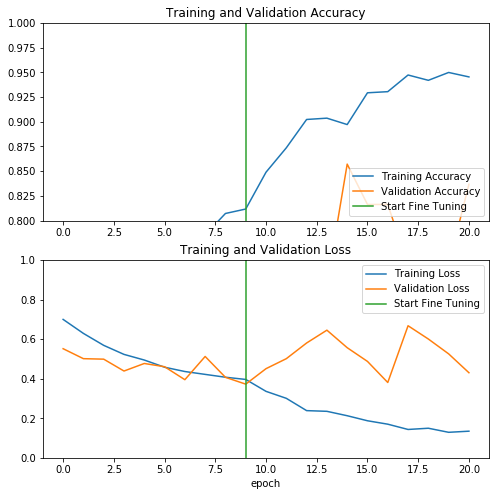

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.81])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Is it any better now?

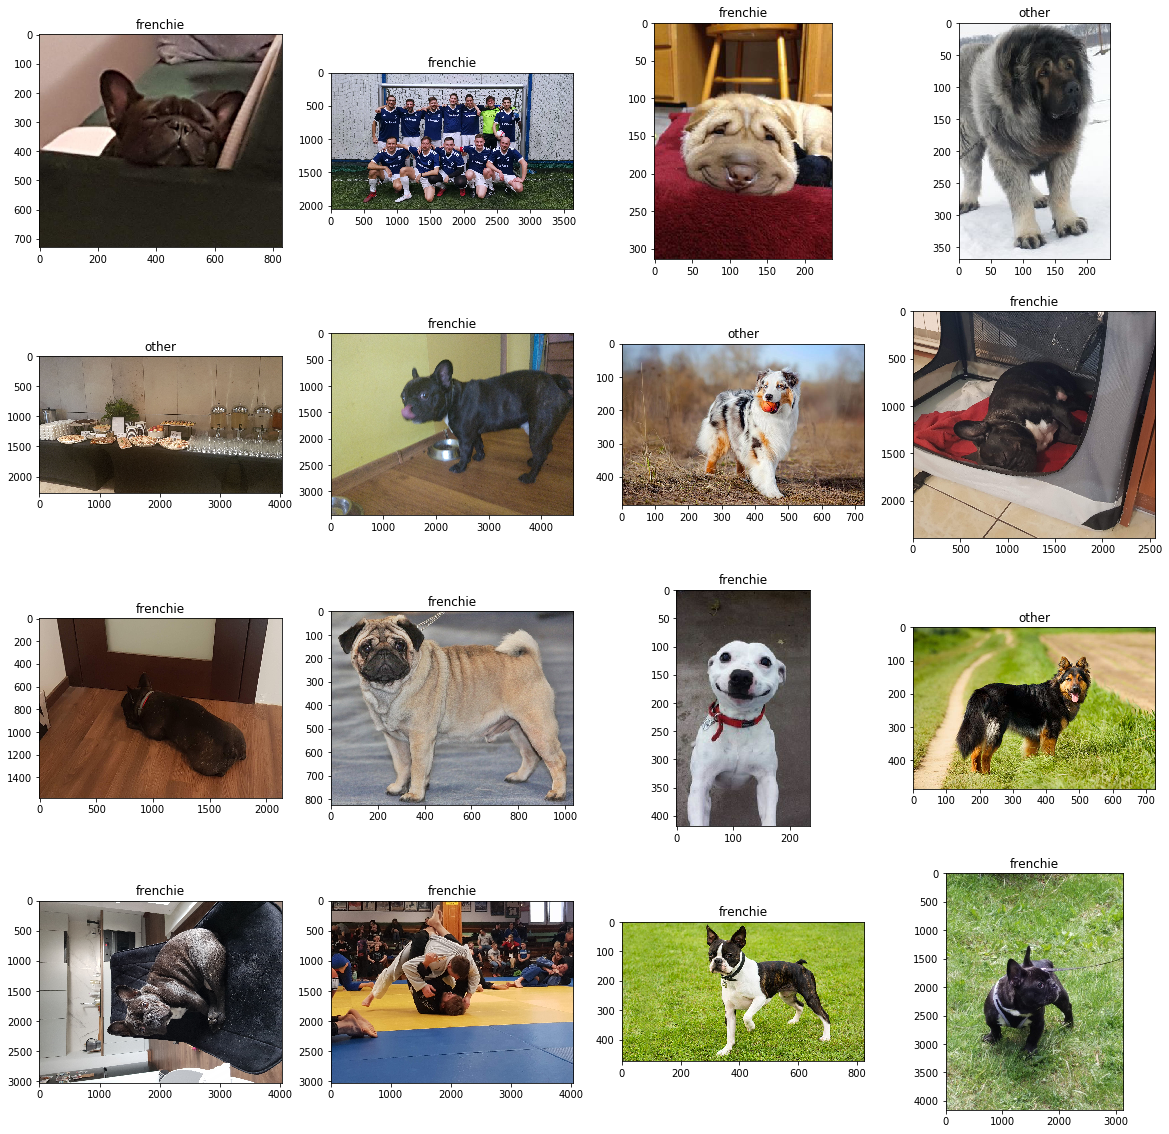

In [30]:
fig=plt.figure(figsize=(20, 20))
img_idx = 1
for (test_image, model_ready_image) in zip(test_images, model_ready_images):
    fig.add_subplot(4, 4, img_idx)
    img_idx = img_idx + 1
    plt.imshow(test_image)
    plt.title(get_label_name(model.predict_classes(np.expand_dims(model_ready_image, axis = 0))))


Think about issues that binary classification has to face!

# Try, read, code and have fun!